In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import gudhi as gd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import PCA

In [ ]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "JPM", "XOM", "CVX"]

prices = yf.download(
    tickers,
    start="2022-01-01",
    end="2024-01-01"
)["Close"]

prices = prices.dropna(how="any")

returns = np.log(prices / prices.shift(1)).dropna(how="any")

[*********************100%***********************]  8 of 8 completed


In [12]:
def graph_and_betti(returns_window, threshold=0.6):
    corr = returns_window.corr().values
    n = corr.shape[0]

    # Build thresholded graph
    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in range(i + 1, n):
            if corr[i, j] >= threshold:
                G.add_edge(i, j)

    # Build simplicial complex (up to triangles)
    st = gd.SimplexTree()

    for v in G.nodes():
        st.insert([v], 0.0)

    for u, v in G.edges():
        st.insert([u, v], 0.0)

    for clique in nx.find_cliques(G):
        if len(clique) == 3:
            st.insert(clique, 0.0)

    st.compute_persistence()
    betti = st.betti_numbers()

    beta0 = betti[0] if len(betti) > 0 else 0
    beta1 = betti[1] if len(betti) > 1 else 0

    return beta0, beta1, G

In [13]:
window_size = 60   # trading days
step = 20
threshold = 0.3

betti_features = []
graphs = []

for start in range(0, len(returns) - window_size, step):
    window = returns.iloc[start:start + window_size]
    beta0, beta1, G = graph_and_betti(window, threshold)

    betti_features.append([beta0, beta1])
    graphs.append(G)

X_betti = np.array(betti_features)

In [14]:
X_scaled = StandardScaler().fit_transform(X_betti)

# Similarity matrix
W = rbf_kernel(X_scaled, gamma=1.0)

sc = SpectralClustering(
    n_clusters=3,
    affinity="precomputed",
    assign_labels="kmeans",
    random_state=42
)

labels = sc.fit_predict(W)


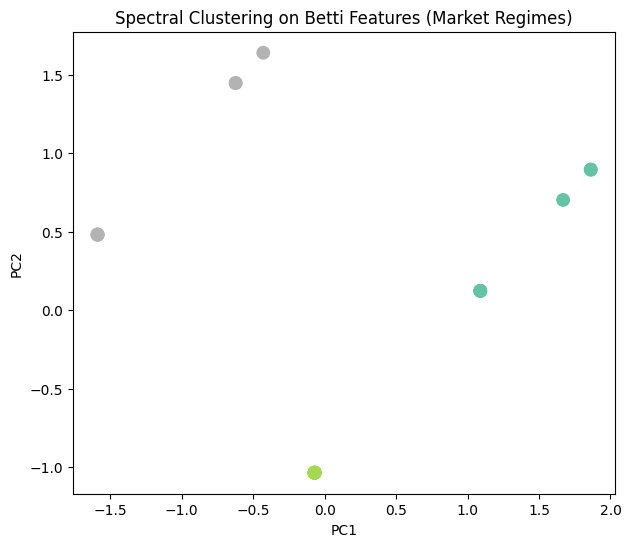

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="Set2", s=80)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Spectral Clustering on Betti Features (Market Regimes)")
plt.show()


In [ ]:
beta0, beta1, G = graph_and_betti(
    returns.iloc[-window_size:], threshold
)

node_features = []

for v in G.nodes():
    node_features.append([
        G.degree(v),
        nx.clustering(G, v),
        beta0,
        beta1
    ])

X_nodes = np.array(node_features)

In [ ]:
Xn_scaled = StandardScaler().fit_transform(X_nodes)
Wn = rbf_kernel(Xn_scaled, gamma=0.5)

sc_nodes = SpectralClustering(
    n_clusters=3,
    affinity="precomputed",
    assign_labels="kmeans",
    random_state=42
)

node_labels = sc_nodes.fit_predict(Wn)

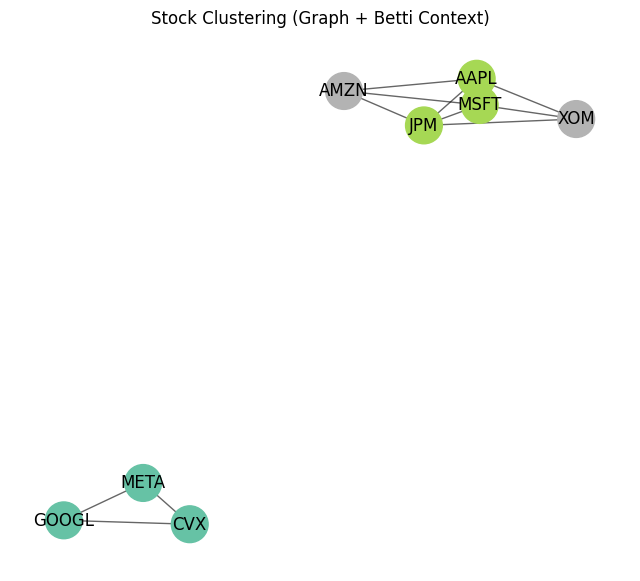

In [ ]:
plt.figure(figsize=(8, 7))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_labels,
    cmap="Set2",
    node_size=700
)

nx.draw_networkx_edges(G, pos, alpha=0.6)
nx.draw_networkx_labels(
    G, pos,
    labels={i: tickers[i] for i in range(len(tickers))}
)

plt.title("Stock Clustering (Graph + Betti Context)")
plt.axis("off")
plt.show()

In [22]:
def betti_curve(returns_window, thresholds):
    beta0_curve = []
    beta1_curve = []

    for tau in thresholds:
        beta0, beta1, _ = graph_and_betti(returns_window, tau)
        beta0_curve.append(beta0)
        beta1_curve.append(beta1)

    return np.array(beta0_curve), np.array(beta1_curve)

In [23]:
thresholds = np.linspace(0.3, 0.9, 15)

betti_curve_features = []

for start in range(0, len(returns) - window_size, step):
    window = returns.iloc[start:start + window_size]
    b0, b1 = betti_curve(window, thresholds)

    # concatenate curves into one feature vector
    betti_curve_features.append(np.concatenate([b0, b1]))

X_betti_curve = np.array(betti_curve_features)

In [24]:
X_scaled = StandardScaler().fit_transform(X_betti_curve)
W = rbf_kernel(X_scaled, gamma=0.5)

labels_betti_curve = SpectralClustering(
    n_clusters=3,
    affinity="precomputed",
    random_state=42
).fit_predict(W)

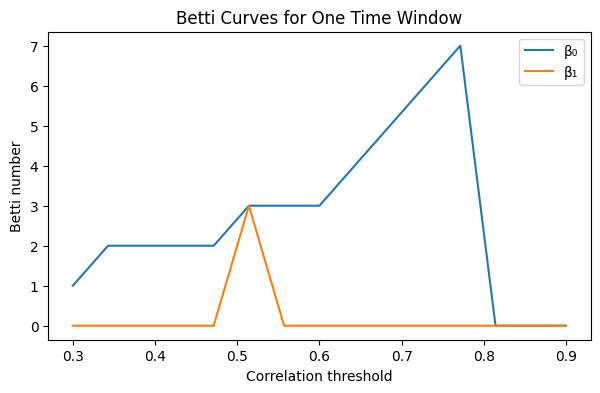

In [25]:
plt.figure(figsize=(7,4))
plt.plot(thresholds, b0, label="β₀")
plt.plot(thresholds, b1, label="β₁")
plt.xlabel("Correlation threshold")
plt.ylabel("Betti number")
plt.legend()
plt.title("Betti Curves for One Time Window")
plt.show()

In [28]:
def persistence_diagram(returns_window, homology_dim=1):
    corr = returns_window.corr().values
    dist = 1 - corr
    np.fill_diagonal(dist, 0)

    rips = gd.RipsComplex(distance_matrix=dist, max_edge_length=1.0)
    st = rips.create_simplex_tree(max_dimension=2)
    st.compute_persistence()

    # Extract diagram for a single dimension
    diag = st.persistence_intervals_in_dimension(homology_dim)

    return diag

In [30]:
from gudhi.representations import PersistenceImage

pim = PersistenceImage(
    bandwidth=0.05,
    weight=lambda p: p[1] - p[0],
    resolution=[20, 20]
)

pi_features = []

for start in range(0, len(returns) - window_size, step):
    window = returns.iloc[start:start + window_size]
    diag = persistence_diagram(window, homology_dim=1)

    if diag.size == 0:
        pi = np.zeros((20 * 20,))
    else:
        pi = pim.fit_transform([diag])[0]

    pi_features.append(pi)

X_pi = np.array(pi_features)

In [31]:
X_scaled = StandardScaler().fit_transform(X_pi)
W = rbf_kernel(X_scaled, gamma=0.2)

labels_pi = SpectralClustering(
    n_clusters=3,
    affinity="precomputed",
    random_state=42
).fit_predict(W)

In [32]:
baseline_features = []

for start in range(0, len(returns) - window_size, step):
    window = returns.iloc[start:start + window_size]
    corr = window.corr().values

    baseline_features.append([
        np.mean(corr),
        np.std(corr),
        np.max(corr)
    ])

X_base = np.array(baseline_features)

Xb = StandardScaler().fit_transform(X_base)
Wb = rbf_kernel(Xb, gamma=1.0)

labels_base = SpectralClustering(
    n_clusters=3,
    affinity="precomputed",
    random_state=42
).fit_predict(Wb)

In [ ]:
from sklearn.metrics import adjusted_rand_score

### ARI measures how similar the clusterings are
print("ARI (Betti curves vs baseline):",
      adjusted_rand_score(labels_base, labels_betti_curve))

print("ARI (Persistence images vs baseline):",
      adjusted_rand_score(labels_base, labels_pi))

ARI (Betti curves vs baseline): 0.33086578693273255
ARI (Persistence images vs baseline): -0.013438204023556381
